# MIMIC-EYE 1.0 - An Eye-Tracking Data Analytics Toolkit for REFLACX and EYE GAZE

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

import numpy as np
import os
import sys
import shutil
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
from mimic.Patient import Patient
from mimic.Xray import Xray
from MIMIC_EYE import MIMIC_EYE 
from Constants import Constants as c
from data.groundtruth.BoundingBox import BoundingBox
from data.groundtruth.Ellipse import Ellipse

from util.mimic_data_processing import *

In [3]:
# starting program
mimic_eye = MIMIC_EYE()

In [4]:
# check if file CACHE_PATH exists
# if it does, load the state
# if it does not, initialize the MIMIC_EYE database
if os.path.exists( c.CACHE_PATH ):
  print("Loading previously saved state...")
  mimic_eye.load_state()
else:
  print("Initializing MIMIC_EYE database...")
  mimic_eye.initialize_mimic_eye()
  mimic_eye.save_state()

Loading previously saved state...


In [5]:
# checking a patient
ref_patient = c.CACHE["PATIENTS"][12629893]
ref_xrays = ref_patient.getXray_lst()
cxr = ref_xrays[0]
cxr.getInfo()

{'ID': 'f0256c5c-a68a55ba-51e7cc78-c6aa82eb-7d0eb5fe',
 'study_id': 's51632471',
 'report': 'FINAL REPORT\nCHEST RADIOGRAPH PERFORMED ON ___\n\nCOMPARISON:  ___.\n\nCLINICAL HISTORY:  Shortness of breath and chest pain.\n\nFINDINGS:  PA and lateral views of the chest were obtained.  Midline\nsternotomy wires and mediastinal clips are again noted. There is a background\nof emphysema better appreciated on the prior radiographs. There has been\ninterval development of pulmonary vascular congestion and mild pulmonary\nedema.  Trace bilateral pleural effusions are present.  No pneumothorax.\nCardiomediastinal silhouette is stable.  Bony structures are intact.\n\nIMPRESSION:  Emphysema with superimposed pulmonary edema.  Trace bilateral\npleural effusions.\n',
 'diagnosis': 'CHF',
 'dicom_path': '/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_12629893/CXR-DICOM/s51632471/f0256c5c-a68a55ba-51e7cc78-c6aa82eb-7d0eb5fe.dcm',
 'jpg_path': '/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_12629893/CXR-JPG/s516324

In [6]:
patient2 = c.CACHE["PATIENTS"][c.CACHE['OVERLAP'][1]]
cxr2 = patient2.getXray_lst()[0]
cxr2

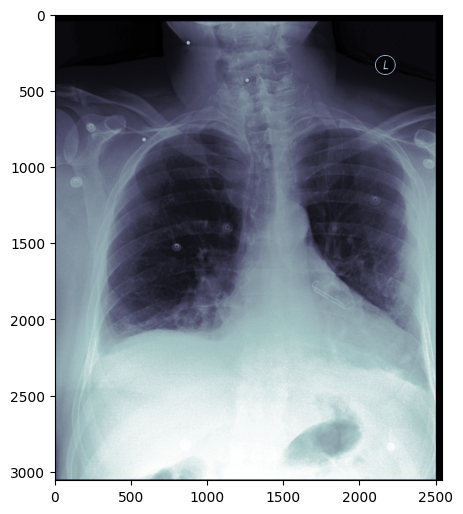

In [7]:
cxr2.xray_figure();

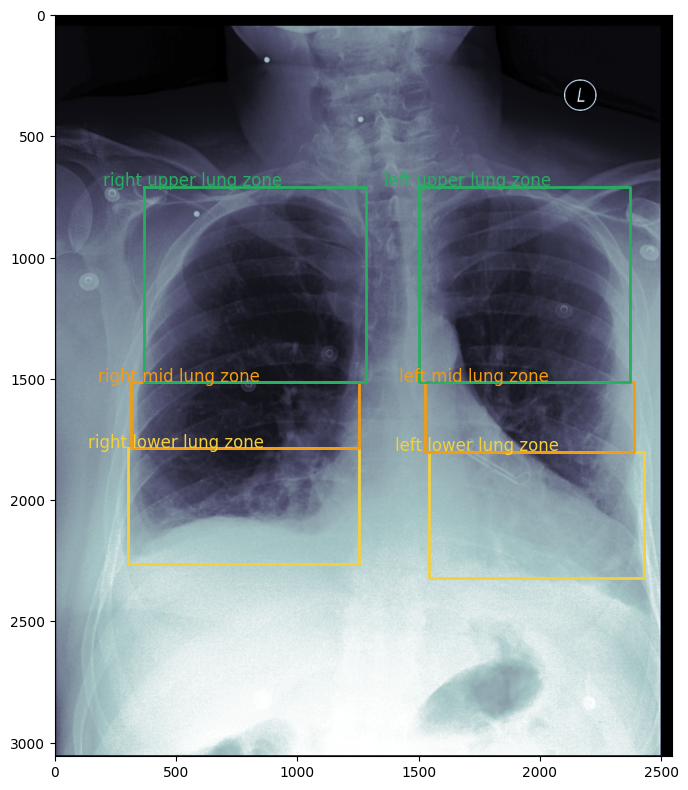

In [8]:
annotation_labels = ["LEFT LOWER LUNG ZONE", "RIGHT LOWER LUNG ZONE", "LEFT MID LUNG ZONE", "RIGHT MID LUNG ZONE", "LEFT UPPER LUNG ZONE", "RIGHT UPPER LUNG ZONE"]
cxr2.plot_bounding_boxess(annotation_labels = annotation_labels, label=True, figsize=(7,10), fontsize=12)


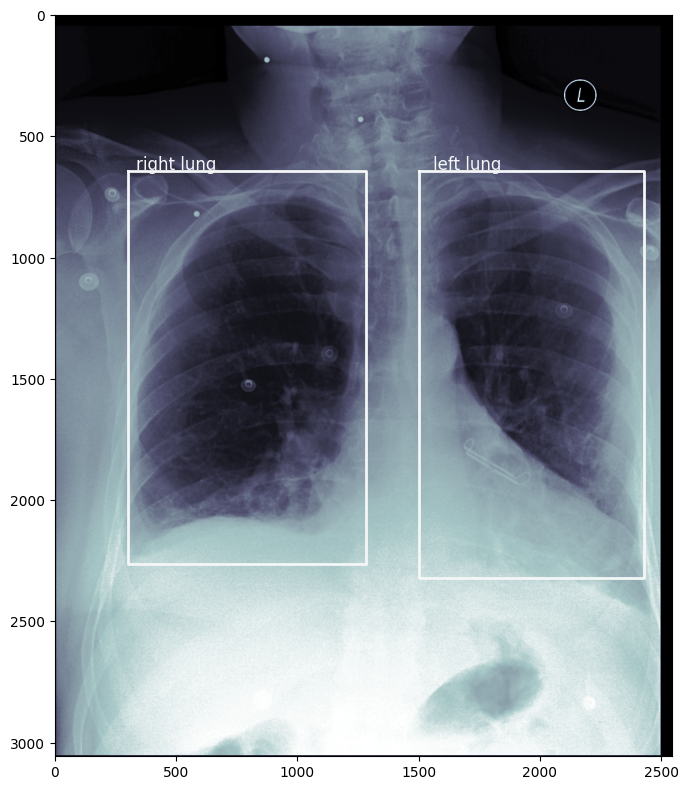

In [9]:
annotation_labels = ["LEFT LUNG","RIGHT LUNG"]
cxr2.plot_bounding_boxess(annotation_labels = annotation_labels, label=True, figsize=(7,10), fontsize=12)

dict_keys(['P300R227438'])
Number of radiologists annotating the image: 1


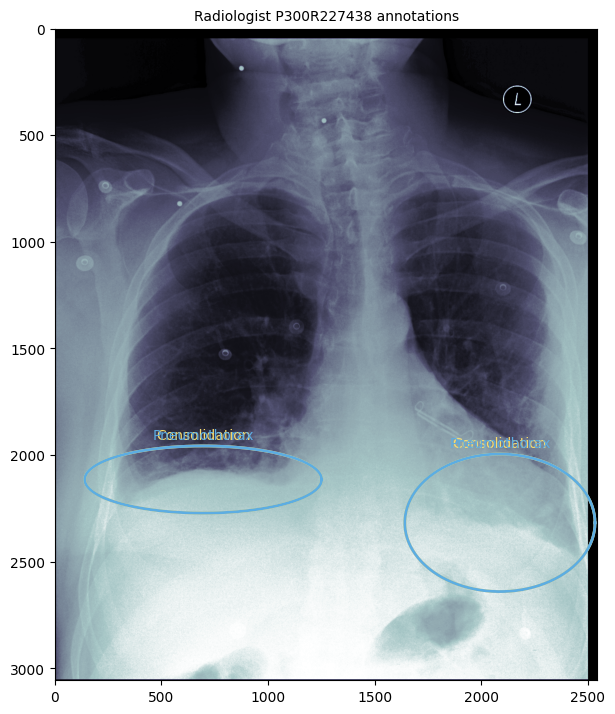

In [10]:
cxr2.plot_abnormalities( figsize=(7,10) );

# EVENT LOG

In [66]:
eye_gaze_sheet =  "/Volumes/SD_DISK/eye_gaze.csv"
gaze_df = pd.read_csv(eye_gaze_sheet)
gaze_df.head()

,SESSION_ID,MEDIA_ID,DICOM_ID,CNT,Time (in secs),TIMETICK(f=10000000),FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,BPOGX,BPOGY,BPOGV,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,RPD,RPS,RPV,BKID,BKDUR,BKPMIN,LPMM,LPMMV,RPMM,RPMMV,SACCADE_MAG,SACCADE_DIR,VID_FRAME,X_ORIGINAL,Y_ORIGINAL
0,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,0.00000,6.962092e+11,0.26427,0.18867,0.00000,0.00000,1,0,0.52854,0.37735,1,0.38281,0.59384,17.19830,0.98505,1,0.64184,0.59797,16.76225,0.98505,1,0,0.22803,20,3.36265,1,3.44732,1,0.0,0.0,0,-2,-2
1,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,1,0.01794,6.962093e+11,0.49027,0.37940,0.00000,0.00000,1,0,0.45200,0.38146,1,0.38156,0.59378,17.47636,0.98505,1,0.64049,0.59770,17.21498,0.98505,1,0,0.00000,20,3.49799,1,3.47886,1,0.0,0.0,0,1216,1159
2,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,2,0.02826,6.962094e+11,0.47102,0.37907,0.00000,0.00000,1,0,0.45178,0.37874,1,0.38054,0.59316,16.56400,0.98505,1,0.63954,0.59721,16.91772,0.99209,1,0,0.00000,20,3.53254,1,3.63720,1,0.0,0.0,0,1105,1158
3,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,3,0.04449,6.962096e+11,0.46275,0.37678,0.00000,0.00000,1,0,0.44619,0.37220,1,0.37976,0.59301,17.02368,0.99209,1,0.63827,0.59704,17.39603,0.99912,1,0,0.00000,20,3.49934,1,3.53357,1,0.0,0.0,0,1058,1151
4,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,4,0.06177,6.962098e+11,0.46065,0.36778,0.01794,0.04382,2,1,0.45437,0.34077,1,0.37967,0.59296,16.84176,0.99912,1,0.63828,0.59696,17.44879,1.00616,1,0,0.00000,20,3.51164,1,3.50221,1,0.0,0.0,0,1046,1123


In [67]:
incosistent_dicoms = ["0cef60b3-64c4072b-ca404ede-defdaa17-2a3", "1e4d4d01-657d797c-f09f7a14-cc14e092-909", "5a63e96d-6cb69582-01b14816-54617171-a4a", "e282f3ae-019457a8-c1ef4c1b-9bda8212-7e3", "4f69aa4e-728ec4e3-2638f625-f79c6003-b3f", "7380429b-0d46e222-7c318aab-a2f09e96-28c", "93934945-8558558c-27fbd30e-b93e422c-2ab", "2a2992bc-ce749b7a-090a94a3-80d7d59c-039", "16344c71-8bd55bc8-952edb72-c361b4e8-c49", "d3a43470-e8e4b5c1-c68c59e1-da71f25a-bdf", "ff25cbf9-6472546a-3242a985-86559865", "826178de-61e5f340-cd1a808b-301b85ff", "58e5ada2-0c5616c3-84aa9df0-26344311-172", "58e5ada2-0c5616c3-84aa9df0-26344311-172", "09133e35-27f3e29d-51feb916-245e2676-c1a", "ebe01445-5da44470-c764513b-644c46a9-d51", "d646869c-07a54ebb-590c4a37-78ac0242-c3e", "116b61ab-7f673ea1-361e4b48-227efb60", "f15fc3ba-51211ef5-3e328c88-4269345b-e75", "724b43fd-ce7cedc5-9d67b476-23e03e3d-650", "aa29a8f7-ec260779-8cb37967-7d5bb1e6-a62", '07886c95-b1f91525-6cc45c85-f0f9d171-2c3', 'b0af618c-5f432fb8-3a5eaf31-23fa161e-e83', 'b966a2fd-63cd10f1-f98c4e5b-b897fa06-a15', '46d83ce2-8ae168fb-e72316f1-ee708ef6-00f', '513be44c-10e46a5f-e6ca83d2-903aef3c-bdd', '92e3ffb0-ef137d7f-51fc0415-7c0f39c4-7bc', '48777fa2-80d72d3c-22727ca9-2678db6b-02f', 'a31c7d93-aaf4925c-94d8ef55-49917cff-9b1', '4f7398d9-c6deb83c-03ffaffc-a69cc0c7-b59', '1abd2f20-b9c6b1c2-c8e85795-b2629533-c21', '02b41933-ca4b4737-a90fecbe-227d7abf-ec5', '504b6eb3-b6e3cc06-c28e8ee2-9aad222b-a5e', 'afb49221-47fc2256-d4651599-4ffa2910-aa5', '7cdf6fec-257d0184-9b794307-56ad845b-760', '67c32b62-a7ddfca1-7e007012-49e725f7-23c', '0e4bc86a-fa844b3b-d783fcea-5d05146d-c5c', '31e8d519-254510ac-f6f72586-c455dfb3-b79', 'c422eb6c-0533ed7e-3fd19570-0ce5ca14-e48', 'efb03b13-c411b791-e39310a3-982c0a38-110', '82a718dc-cca0364e-f43f99d8-1a3e42d5', '320df379-5ac0ef5d-a88bd5b6-e0620b99-7ca7bbfe_calibration', 'b96a0e37-58c07bab-a5dd12b9-ad43c6d3-7fa', '0cef60b3-64c4072b-ca404ede-defdaa17-2a3', 'ad126858-3904d3c7-13e487ee-79a9b1e2-55d', '0c68040c-5815cb50-ffa019c3-4b146302-360', '7d83174c-0841b8bd-62943e22-8a138bec-65b', 'cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b3', '35fdf17d-f25750ed-6385bb37-d52d7e98-3f0', '27298da3-1d4fce76-c7036219-0dcc9633-cb1', 'edc60628-709804d5-57432799-f6d8d8e0-29a', '09d2c414-e5771ae7-08d7cd74-5c5ba589-38d', '32b99644-727466d9-39f06e69-12edef4c-b39', '36e73bcc-02a0174c-03d21a60-e442afe0-56a', '17599eb3-173fc22b-84db3c0b-9639c478-d0d', '63304715-b1fad079-d2295ec2-4961f2d0-92d', '0e923b0b-93746811-3ffa73b1-9baabf54-6b1', 'e435656e-c2bcf67d-ac123c19-834cccab-4ab', 'ae6087cb-92ba1dc3-e0e0234f-8d859a0e-f2e', 'e7cde21b-64b73cfd-a502911d-aa487720-a7e', '1f57a2e2-d01c5591-88328517-07bf57f4-e3e' ]
corrected_dicoms =   ["0cef60b3-64c4072b-ca404ede-defdaa17-2a330695", "1e4d4d01-657d797c-f09f7a14-cc14e092-909e66b8", "5a63e96d-6cb69582-01b14816-54617171-a4a4b011", "e282f3ae-019457a8-c1ef4c1b-9bda8212-7e3754ef", "4f69aa4e-728ec4e3-2638f625-f79c6003-b3fc8e94", "7380429b-0d46e222-7c318aab-a2f09e96-28c41db4", "93934945-8558558c-27fbd30e-b93e422c-2ab6da8d", "2a2992bc-ce749b7a-090a94a3-80d7d59c-039fc25f", "16344c71-8bd55bc8-952edb72-c361b4e8-c4980ee1", "d3a43470-e8e4b5c1-c68c59e1-da71f25a-bdfce462", "ff25cbf9-6472546a-3242a985-86559865-fd9cad7c", "826178de-61e5f340-cd1a808b-301b85ff-22320d04", "58e5ada2-0c5616c3-84aa9df0-26344311-172732ac", "58e5ada2-0c5616c3-84aa9df0-26344311-172732ac", "09133e35-27f3e29d-51feb916-245e2676-c1aa0a04", "ebe01445-5da44470-c764513b-644c46a9-d51b9dab", "d646869c-07a54ebb-590c4a37-78ac0242-c3e2985d", "116b61ab-7f673ea1-361e4b48-227efb60-835aee93", "f15fc3ba-51211ef5-3e328c88-4269345b-e75dc73a", "724b43fd-ce7cedc5-9d67b476-23e03e3d-650cbb41", "aa29a8f7-ec260779-8cb37967-7d5bb1e6-a623e93f",  "07886c95-b1f91525-6cc45c85-f0f9d171-2c319917", "b0af618c-5f432fb8-3a5eaf31-23fa161e-e837cb84", "b966a2fd-63cd10f1-f98c4e5b-b897fa06-a1520bac", "46d83ce2-8ae168fb-e72316f1-ee708ef6-00f3f444", "513be44c-10e46a5f-e6ca83d2-903aef3c-bdd045fe", "92e3ffb0-ef137d7f-51fc0415-7c0f39c4-7bc16d08", "48777fa2-80d72d3c-22727ca9-2678db6b-02fa73ff", "a31c7d93-aaf4925c-94d8ef55-49917cff-9b1cbeef", "4f7398d9-c6deb83c-03ffaffc-a69cc0c7-b59ad58f", "1abd2f20-b9c6b1c2-c8e85795-b2629533-c2158f0f", "02b41933-ca4b4737-a90fecbe-227d7abf-ec5ddcca", "504b6eb3-b6e3cc06-c28e8ee2-9aad222b-a5eac0d1", "afb49221-47fc2256-d4651599-4ffa2910-aa54449b", "7cdf6fec-257d0184-9b794307-56ad845b-760d323a", "67c32b62-a7ddfca1-7e007012-49e725f7-23ca9ef7", "0e4bc86a-fa844b3b-d783fcea-5d05146d-c5cf6691", "31e8d519-254510ac-f6f72586-c455dfb3-b7969d60", "c422eb6c-0533ed7e-3fd19570-0ce5ca14-e48009ef", "efb03b13-c411b791-e39310a3-982c0a38-1100ccc8", "82a718dc-cca0364e-f43f99d8-1a3e42d5-c70540f8", "320df379-5ac0ef5d-a88bd5b6-e0620b99-7ca7bbfe", "b96a0e37-58c07bab-a5dd12b9-ad43c6d3-7faf8190", "0cef60b3-64c4072b-ca404ede-defdaa17-2a3", "ad126858-3904d3c7-13e487ee-79a9b1e2-55dbef5f", "0c68040c-5815cb50-ffa019c3-4b146302-3607e1bd", "7d83174c-0841b8bd-62943e22-8a138bec-65ba724d", "cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520", "35fdf17d-f25750ed-6385bb37-d52d7e98-3f0f9879", "27298da3-1d4fce76-c7036219-0dcc9633-cb1a7c9b", "edc60628-709804d5-57432799-f6d8d8e0-29acc87a", "09d2c414-e5771ae7-08d7cd74-5c5ba589-38d283a8", "32b99644-727466d9-39f06e69-12edef4c-b39d2f1c", "36e73bcc-02a0174c-03d21a60-e442afe0-56a047d1", "17599eb3-173fc22b-84db3c0b-9639c478-d0db6bc2", "63304715-b1fad079-d2295ec2-4961f2d0-92d7ca4b", "0e923b0b-93746811-3ffa73b1-9baabf54-6b16de2a", "e435656e-c2bcf67d-ac123c19-834cccab-4abceb1a", "ae6087cb-92ba1dc3-e0e0234f-8d859a0e-f2ec8bfe", "e7cde21b-64b73cfd-a502911d-aa487720-a7e4d279", "1f57a2e2-d01c5591-88328517-07bf57f4-e3e20afa"]

for indx in gaze_df.index:
  dicom_id = gaze_df.loc[indx, 'DICOM_ID']
  for i in range(0, len(incosistent_dicoms)):
    if dicom_id == incosistent_dicoms[i]:
      gaze_df.loc[indx, 'DICOM_ID'] = corrected_dicoms[i]
      break


In [68]:
event_df = gaze_df[["DICOM_ID", "MEDIA_ID", "SESSION_ID", "Time (in secs)", "X_ORIGINAL", "Y_ORIGINAL", "LPMM", "RPMM" ]].copy()
event_df["PUPIL"] = (gaze_df.LPMM + gaze_df.RPMM)/2
event_df["START_TIMESTAMP"] = np.zeros(len(event_df))
event_df["END_TIMESTAMP"] = np.zeros(len(event_df))
event_df["ALL_INTERSECTIONS"] = None
event_df["MIN_INTERSECTION_AREA"] = None
event_df["MAX_INTERSECTION_AREA"] = None
event_df["IS_SILENT?"] = None
event_df["DIAGNOSIS"] = None
event_df = event_df[(event_df.X_ORIGINAL >= 0) & (event_df.Y_ORIGINAL >= 0)] # remove negative X,Y values
event_df = event_df[event_df["Time (in secs)"] > 0]                          # remove fixations with 0 seconds
event_df.drop(["LPMM", "RPMM"], axis=1, inplace=True)
event_df.rename(columns={"DICOM_ID": "CASE_ID"}, inplace=True)
event_df.reset_index(drop=True, inplace=True)
event_df.head(10)

,CASE_ID,MEDIA_ID,SESSION_ID,Time (in secs),X_ORIGINAL,Y_ORIGINAL,PUPIL,START_TIMESTAMP,END_TIMESTAMP,ALL_INTERSECTIONS,MIN_INTERSECTION_AREA,MAX_INTERSECTION_AREA,IS_SILENT?,DIAGNOSIS
0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.01794,1216,1159,3.488425,0.0,0.0,None,None,None,None,None
1,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.02826,1105,1158,3.584870,0.0,0.0,None,None,None,None,None
2,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.04449,1058,1151,3.516455,0.0,0.0,None,None,None,None,None
3,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.06177,1046,1123,3.506925,0.0,0.0,None,None,None,None,None
4,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.07672,1038,1105,3.528835,0.0,0.0,None,None,None,None,None
5,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.09283,1025,1095,3.592625,0.0,0.0,None,None,None,None,None
6,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.10913,1002,1086,3.496280,0.0,0.0,None,None,None,None,None
7,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.12610,985,1081,3.613085,0.0,0.0,None,None,None,None,None
8,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.14130,988,1084,3.598610,0.0,0.0,None,None,None,None,None
9,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,1,0.15814,986,1090,3.633865,0.0,0.0,None,None,None,None,None


In [69]:
metadata = pd.read_csv("/Volumes/SD_DISK/master_sheet.csv")
metadata = metadata[["dicom_id", "Normal", "CHF", "pneumonia"]].copy()
metadata["diagnosis"] = np.zeros(len(metadata))

for indx in metadata.index:
  if metadata.loc[indx, "Normal"] == 1:
    metadata.loc[indx,"diagnosis"] = "Normal"

  if metadata.loc[indx, "CHF"] == 1:
    metadata.loc[indx,"diagnosis"] = "CHF"

  if metadata.loc[indx, "pneumonia"] == 1:
    metadata.loc[indx, "diagnosis"] = "Pneumonia"
metadata.drop(["Normal", "CHF", "pneumonia"], axis=1, inplace=True)
metadata.head(10)

,dicom_id,diagnosis
0,24c7496c-d7635dfe-b8e0b87f-d818affc-78ff7cf4,CHF
1,78711a04-264d5305-d5feec9b-ebef1cec-fdc6db9c,CHF
2,a770d8d6-7b6a62ff-815ab876-c81709a8-9a654a54,CHF
3,8e457921-bc1af8aa-a65073c1-aaac8247-c5ceb780,CHF
4,62fe5d5a-1806ee3c-f4e742fa-f2b036ea-d390057a,CHF
5,64beda42-873c8a44-3d9d3073-33372d32-dee84707,CHF
6,748991dc-fb330cd1-fc203d00-b89b5ccb-7995b475,CHF
7,e5d1f575-e201925f-3d0faf91-7c8d8e98-b2550d52,CHF
8,f0266425-1de60bab-cabee003-da9aa11e-49a31ace,CHF
9,6ff76a0c-49246bc5-a7c149d1-59dc38d9-c11b7ec7,CHF


In [70]:
bbox_df = pd.read_csv("/Volumes/SD_DISK/bounding_boxes.csv")
bbox_df.head()

,dicom_id,bbox_name,x1,x2,y1,y2
0,002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48,cardiac silhouette,1007.0,1743.0,1278.0,2040.0
1,002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48,left clavicle,1369.0,2363.0,309.0,671.0
2,002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48,left costophrenic angle,2105.0,2363.0,2156.0,2415.0
3,002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48,left hilar structures,1356.0,1782.0,865.0,1562.0
4,002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48,left lower lung zone,1381.0,2247.0,1472.0,2363.0


In [16]:
# anatomical regions to remove
bbox_df = bbox_df[ bbox_df["bbox_name"] != "trachea" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "right upper lung zone" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "left upper lung zone" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "right lower lung zone" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "left lower lung zone" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "right mid lung zone" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "left mid lung zone" ]
bbox_df.shape

(10824, 6)

In [16]:
# anatomical regions to remove
bbox_df = bbox_df[ bbox_df["bbox_name"] != "trachea" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "right lung" ]
bbox_df = bbox_df[ bbox_df["bbox_name"] != "left lung" ]
bbox_df.shape

(15156, 6)

In [17]:
from datetime import datetime
from data.groundtruth.BoundingBox import BoundingBox


In [78]:
SECONDS_IN_A_DAY = 0
DAY = 0

not_found = []
print(len(event_df.SESSION_ID.unique()))
for session in event_df.SESSION_ID.unique():
  print(f"Session: {session}")
  
  if len(np.unique(not_found)) > 0:
    print(f"Not found = {np.unique(not_found)}")

  media_df = event_df[event_df.SESSION_ID == session]
  for media in media_df.MEDIA_ID.unique():
    start_seconds = DAY*SECONDS_IN_A_DAY

    event_sample = event_df[ (event_df["SESSION_ID"] == session) & (event_df["MEDIA_ID"] == media)]
    dicom_id = event_sample.CASE_ID.values[0]

    # get the time in secs when the radiologist starts to read the dicom image
    xray = c.CACHE["DICOM_TO_XRAY"][dicom_id]
    transcript_dict = xray.getAudioTranscriptsDict()
    for key in transcript_dict.keys():
      if "P" in key:
        continue # found REFLACX reading, ignore
      transcript = pd.read_json(transcript_dict[key])
      starting_transcript_time = transcript["time_stamped_text"][0]["begin_time"]
      break
    
    # print(f"SESSION ID {session}\t MEDIA ID {media}\t transcript time {starting_transcript_time}")
    for indx in event_sample.index:
      
      start_time = datetime.fromtimestamp(start_seconds).strftime("%Y-%m-%d %H:%M:%S.%f")
      end_seconds = event_df.loc[indx, "Time (in secs)"] + DAY*SECONDS_IN_A_DAY
      end_time   = datetime.fromtimestamp(end_seconds).strftime("%Y-%m-%d %H:%M:%S.%f")

      event_df.loc[indx,"START_TIMESTAMP"]= start_time
      event_df.loc[indx,"END_TIMESTAMP"] = end_time

      event_df.loc[indx, "IS_SILENT?"] = 0 if starting_transcript_time <= event_df.loc[indx, "Time (in secs)"] else 1
      
      event_bboxes_df = bbox_df[ bbox_df.dicom_id == dicom_id ]
      try:
        event_df.loc[indx,"DIAGNOSIS"] = metadata[ metadata.dicom_id == dicom_id ].diagnosis.values[0]
      except:
        event_df.loc[indx,"DIAGNOSIS"] = "Not Found"
        not_found.append(dicom_id)
        
      b_candidates = {}
      for bindx in event_bboxes_df.index:
        bbox = BoundingBox(event_bboxes_df.loc[bindx, "x1"], event_bboxes_df.loc[bindx, "x2"],\
                           event_bboxes_df.loc[bindx, "y1"], event_bboxes_df.loc[bindx, "y2"], event_bboxes_df.loc[bindx, "bbox_name"] )
        
        # check if gaze falls inside the bbox
        if bbox.is_point_inside_shape(event_sample.X_ORIGINAL[indx], event_sample.Y_ORIGINAL[indx]):
          b_candidates[bbox.getLabel()] = bbox.area()
    
      # get the key with the maximum value
      if len(b_candidates) > 0:
        max_key = max(b_candidates, key=b_candidates.get)
        min_key = min(b_candidates, key=b_candidates.get)

        event_df.loc[indx,"ALL_INTERSECTIONS"] = str(list(b_candidates.keys()))
        event_df.loc[indx,"MIN_INTERSECTION_AREA"] = min_key
        event_df.loc[indx,"MAX_INTERSECTION_AREA"] = max_key
      else:
        event_df.loc[indx,"ALL_INTERSECTIONS"] = "Area Out of Bounding Boxes"
        event_df.loc[indx,"MIN_INTERSECTION_AREA"] = "Area Out of Bounding Boxes"
        event_df.loc[indx,"MAX_INTERSECTION_AREA"] = "Area Out of Bounding Boxes"
      
      # the next start time is the current end time + 0.00001
      start_seconds = end_seconds + 0.000001

    DAY = DAY + 1


38
Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38


In [19]:
print("this is a test")


this is a test


In [20]:
event_df.to_csv("/Volumes/SD_DISK/timestamps_WITHOUT_lung_specific.csv", index=False)

In [61]:
event_df = pd.read_csv("/Volumes/SD_DISK/timestamps_GENERAL.csv")

In [62]:
from datetime import datetime


new_event_df = pd.DataFrame(columns=event_df.columns)

sample = event_df

new_indx = 0
start_indx = sample.index[0]
prev_state = sample.loc[start_indx, "MIN_INTERSECTION_AREA"]
prev_start_time = sample.loc[start_indx, "START_TIMESTAMP"]

x_coords = [ sample.loc[start_indx, "X_ORIGINAL"] ]
y_coords = [ sample.loc[start_indx, "Y_ORIGINAL"] ]
pupil = [sample.loc[start_indx, "PUPIL"] ]

for indx in sample.index[1:]:

  if sample.loc[indx, "MIN_INTERSECTION_AREA"] == prev_state:
    x_coords.append(sample.loc[indx, "X_ORIGINAL"])
    y_coords.append(sample.loc[indx, "Y_ORIGINAL"])
    pupil.append(sample.loc[indx, "PUPIL"])
    continue
  else:
    
    new_event_df.loc[new_indx,"START_TIMESTAMP"]= prev_start_time
    new_event_df.loc[new_indx,"END_TIMESTAMP"] =  sample.loc[indx-1, "END_TIMESTAMP"]

    new_event_df.loc[new_indx,"SESSION_ID"] = sample.loc[indx-1 , "SESSION_ID"]
    new_event_df.loc[new_indx,"MEDIA_ID"] = sample.loc[indx-1, "MEDIA_ID"]
    
    new_event_df.loc[new_indx, "MIN_INTERSECTION_AREA"] = sample.loc[indx-1, "MIN_INTERSECTION_AREA"]
    new_event_df.loc[new_indx, "MAX_INTERSECTION_AREA"] = sample.loc[indx-1, "MAX_INTERSECTION_AREA"]
    new_event_df.loc[new_indx, "Time (in secs)"] = sample.loc[indx-1, "Time (in secs)"]

    new_event_df.loc[new_indx, "X_ORIGINAL"] = np.mean(x_coords)
    new_event_df.loc[new_indx, "Y_ORIGINAL"] = np.mean(y_coords)
    new_event_df.loc[new_indx, "PUPIL"] = np.mean(pupil)

    new_event_df.loc[new_indx, "CASE_ID"] = sample.loc[indx-1, "CASE_ID"]
    new_event_df.loc[new_indx, "DIAGNOSIS"] = sample.loc[indx-1, "DIAGNOSIS"]
    new_event_df.loc[new_indx, "IS_SILENT?"] = sample.loc[indx-1, "IS_SILENT?"]


    start_indx = indx
    prev_start_time = sample.loc[start_indx, "START_TIMESTAMP"]
    prev_state = sample.loc[start_indx, "MIN_INTERSECTION_AREA"]


    x_coords = [ sample.loc[start_indx, "X_ORIGINAL"] ]
    y_coords = [ sample.loc[start_indx, "Y_ORIGINAL"] ]
    pupil = [sample.loc[start_indx, "PUPIL"] ]

    new_indx = new_indx + 1
  
new_event_df.loc[new_indx,"START_TIMESTAMP"]= prev_start_time
new_event_df.loc[new_indx,"END_TIMESTAMP"] =  sample.loc[indx-1, "END_TIMESTAMP"]

new_event_df.loc[new_indx,"SESSION_ID"] = sample.loc[indx-1 , "SESSION_ID"]
new_event_df.loc[new_indx,"MEDIA_ID"] = sample.loc[indx-1, "MEDIA_ID"]

new_event_df.loc[new_indx, "MIN_INTERSECTION_AREA"] = sample.loc[indx-1, "MIN_INTERSECTION_AREA"]
new_event_df.loc[new_indx, "MAX_INTERSECTION_AREA"] = sample.loc[indx-1, "MAX_INTERSECTION_AREA"]
new_event_df.loc[new_indx, "Time (in secs)"] = sample.loc[indx-1, "Time (in secs)"]

new_event_df.loc[new_indx, "X_ORIGINAL"] = np.mean(x_coords)
new_event_df.loc[new_indx, "Y_ORIGINAL"] = np.mean(y_coords)
new_event_df.loc[new_indx, "PUPIL"] = np.mean(pupil)

new_event_df.loc[new_indx, "CASE_ID"] = sample.loc[indx-1, "CASE_ID"]
new_event_df.loc[new_indx, "DIAGNOSIS"] = sample.loc[indx-1, "DIAGNOSIS"]
new_event_df.loc[new_indx, "IS_SILENT?"] = sample.loc[indx-1, "IS_SILENT?"]




In [63]:
new_event_df.to_csv("/Volumes/SD_DISK/timestamps_GENERAL_COMPACT.csv")


In [64]:
event_df = pd.read_csv("/Volumes/SD_DISK/timestamps_SPECIFIC.csv")

from datetime import datetime


new_event_df = pd.DataFrame(columns=event_df.columns)

sample = event_df

new_indx = 0
start_indx = sample.index[0]
prev_state = sample.loc[start_indx, "MIN_INTERSECTION_AREA"]
prev_start_time = sample.loc[start_indx, "START_TIMESTAMP"]

x_coords = [ sample.loc[start_indx, "X_ORIGINAL"] ]
y_coords = [ sample.loc[start_indx, "Y_ORIGINAL"] ]
pupil = [sample.loc[start_indx, "PUPIL"] ]

for indx in sample.index[1:]:

  if sample.loc[indx, "MIN_INTERSECTION_AREA"] == prev_state:
    x_coords.append(sample.loc[indx, "X_ORIGINAL"])
    y_coords.append(sample.loc[indx, "Y_ORIGINAL"])
    pupil.append(sample.loc[indx, "PUPIL"])
    continue
  else:
    
    new_event_df.loc[new_indx,"START_TIMESTAMP"]= prev_start_time
    new_event_df.loc[new_indx,"END_TIMESTAMP"] =  sample.loc[indx-1, "END_TIMESTAMP"]

    new_event_df.loc[new_indx,"SESSION_ID"] = sample.loc[indx-1 , "SESSION_ID"]
    new_event_df.loc[new_indx,"MEDIA_ID"] = sample.loc[indx-1, "MEDIA_ID"]
    
    new_event_df.loc[new_indx, "MIN_INTERSECTION_AREA"] = sample.loc[indx-1, "MIN_INTERSECTION_AREA"]
    new_event_df.loc[new_indx, "MAX_INTERSECTION_AREA"] = sample.loc[indx-1, "MAX_INTERSECTION_AREA"]
    new_event_df.loc[new_indx, "Time (in secs)"] = sample.loc[indx-1, "Time (in secs)"]

    new_event_df.loc[new_indx, "X_ORIGINAL"] = np.mean(x_coords)
    new_event_df.loc[new_indx, "Y_ORIGINAL"] = np.mean(y_coords)
    new_event_df.loc[new_indx, "PUPIL"] = np.mean(pupil)

    new_event_df.loc[new_indx, "CASE_ID"] = sample.loc[indx-1, "CASE_ID"]
    new_event_df.loc[new_indx, "DIAGNOSIS"] = sample.loc[indx-1, "DIAGNOSIS"]
    new_event_df.loc[new_indx, "IS_SILENT?"] = sample.loc[indx-1, "IS_SILENT?"]


    start_indx = indx
    prev_start_time = sample.loc[start_indx, "START_TIMESTAMP"]
    prev_state = sample.loc[start_indx, "MIN_INTERSECTION_AREA"]


    x_coords = [ sample.loc[start_indx, "X_ORIGINAL"] ]
    y_coords = [ sample.loc[start_indx, "Y_ORIGINAL"] ]
    pupil = [sample.loc[start_indx, "PUPIL"] ]

    new_indx = new_indx + 1
  
new_event_df.loc[new_indx,"START_TIMESTAMP"]= prev_start_time
new_event_df.loc[new_indx,"END_TIMESTAMP"] =  sample.loc[indx-1, "END_TIMESTAMP"]

new_event_df.loc[new_indx,"SESSION_ID"] = sample.loc[indx-1 , "SESSION_ID"]
new_event_df.loc[new_indx,"MEDIA_ID"] = sample.loc[indx-1, "MEDIA_ID"]

new_event_df.loc[new_indx, "MIN_INTERSECTION_AREA"] = sample.loc[indx-1, "MIN_INTERSECTION_AREA"]
new_event_df.loc[new_indx, "MAX_INTERSECTION_AREA"] = sample.loc[indx-1, "MAX_INTERSECTION_AREA"]
new_event_df.loc[new_indx, "Time (in secs)"] = sample.loc[indx-1, "Time (in secs)"]

new_event_df.loc[new_indx, "X_ORIGINAL"] = np.mean(x_coords)
new_event_df.loc[new_indx, "Y_ORIGINAL"] = np.mean(y_coords)
new_event_df.loc[new_indx, "PUPIL"] = np.mean(pupil)

new_event_df.loc[new_indx, "CASE_ID"] = sample.loc[indx-1, "CASE_ID"]
new_event_df.loc[new_indx, "DIAGNOSIS"] = sample.loc[indx-1, "DIAGNOSIS"]
new_event_df.loc[new_indx, "IS_SILENT?"] = sample.loc[indx-1, "IS_SILENT?"]


new_event_df.to_csv("/Volumes/SD_DISK/timestamps_SPECIFIC_COMPACT.csv")

In [65]:

import seaborn as sns
sns.set(style="whitegrid")

In [68]:
event_df = pd.read_csv("/Volumes/SD_DISK/timestamps_GENERAL.csv")

In [74]:
event_df[ (event_df.DIAGNOSIS == "Normal") & (event_df["IS_SILENT?"] == 1) ]

,CASE_ID,MEDIA_ID,SESSION_ID,Time (in secs),X_ORIGINAL,Y_ORIGINAL,PUPIL,START_TIMESTAMP,END_TIMESTAMP,ALL_INTERSECTIONS,MIN_INTERSECTION_AREA,MAX_INTERSECTION_AREA,IS_SILENT?,DIAGNOSIS
2722,4df0c412-e01a6486-acd5ab0b-e6e4aa31-d6773e42,3,1,0.01630,2096,2340,3.470840,1970-01-01 01:00:00.000000,1970-01-01 01:00:00.016300,['left lung'],left lung,left lung,1,Normal
2723,4df0c412-e01a6486-acd5ab0b-e6e4aa31-d6773e42,3,1,0.03241,2099,2337,3.455140,1970-01-01 01:00:00.016301,1970-01-01 01:00:00.032410,['left lung'],left lung,left lung,1,Normal
2724,4df0c412-e01a6486-acd5ab0b-e6e4aa31-d6773e42,3,1,0.04852,2102,2334,3.658400,1970-01-01 01:00:00.032411,1970-01-01 01:00:00.048520,['left lung'],left lung,left lung,1,Normal
2725,4df0c412-e01a6486-acd5ab0b-e6e4aa31-d6773e42,3,1,0.06458,2100,2290,3.467360,1970-01-01 01:00:00.048521,1970-01-01 01:00:00.064580,['left lung'],left lung,left lung,1,Normal
2726,4df0c412-e01a6486-acd5ab0b-e6e4aa31-d6773e42,3,1,0.08124,2137,2154,3.413180,1970-01-01 01:00:00.064581,1970-01-01 01:00:00.081240,['left lung'],left lung,left lung,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370926,ea1fa8fb-cfc6b7cc-706e8d25-1f94cb8c-0d095386,26,38,2.23047,2742,2424,3.014605,1970-01-01 01:00:02.214361,1970-01-01 01:00:02.230470,['left lung'],left lung,left lung,1,Normal
1370927,ea1fa8fb-cfc6b7cc-706e8d25-1f94cb8c-0d095386,26,38,2.24609,2742,2426,3.080150,1970-01-01 01:00:02.230471,1970-01-01 01:00:02.246090,['left lung'],left lung,left lung,1,Normal
1370928,ea1fa8fb-cfc6b7cc-706e8d25-1f94cb8c-0d095386,26,38,2.26270,2743,2428,3.120610,1970-01-01 01:00:02.246091,1970-01-01 01:00:02.262700,['left lung'],left lung,left lung,1,Normal
1370929,ea1fa8fb-cfc6b7cc-706e8d25-1f94cb8c-0d095386,26,38,2.27832,2744,2429,3.130615,1970-01-01 01:00:02.262701,1970-01-01 01:00:02.278320,['left lung'],left lung,left lung,1,Normal


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


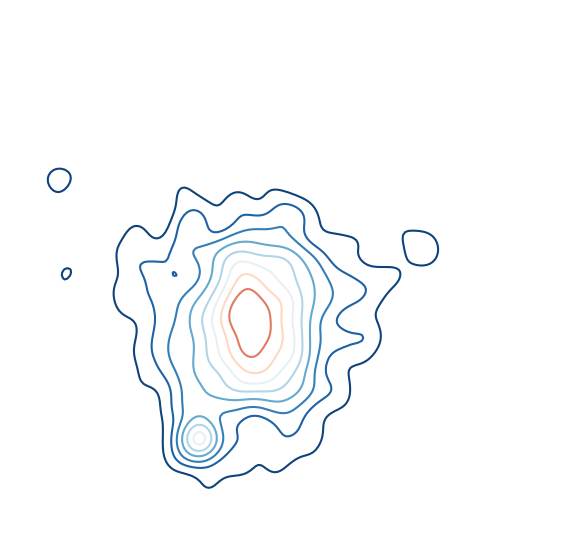

In [81]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "Normal") & (event_df["IS_SILENT?"] == 1) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


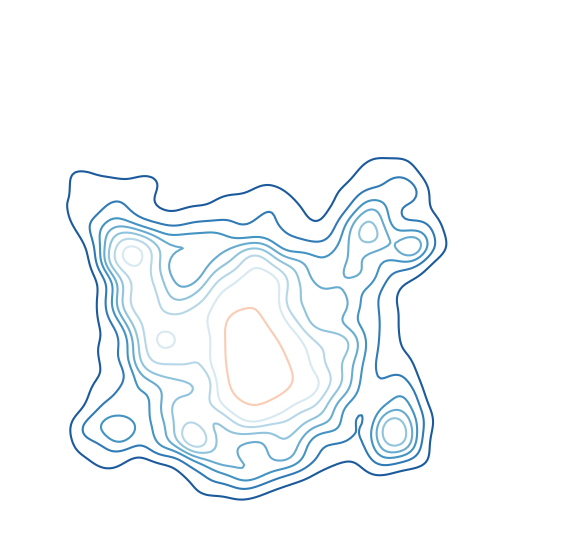

In [82]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "Normal") & (event_df["IS_SILENT?"] == 0) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


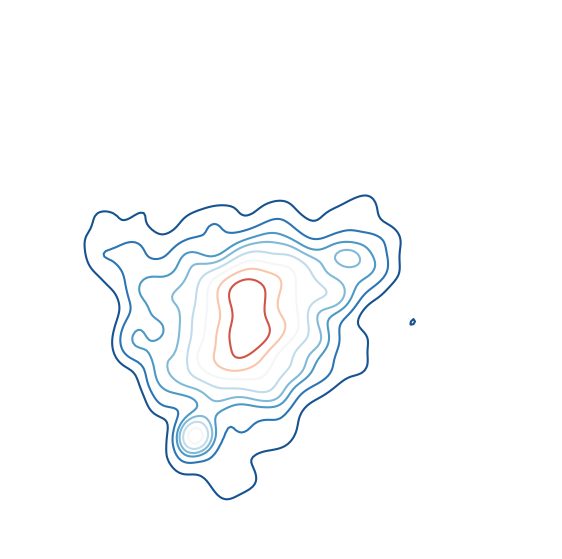

In [83]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "Pneumonia") & (event_df["IS_SILENT?"] == 1) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


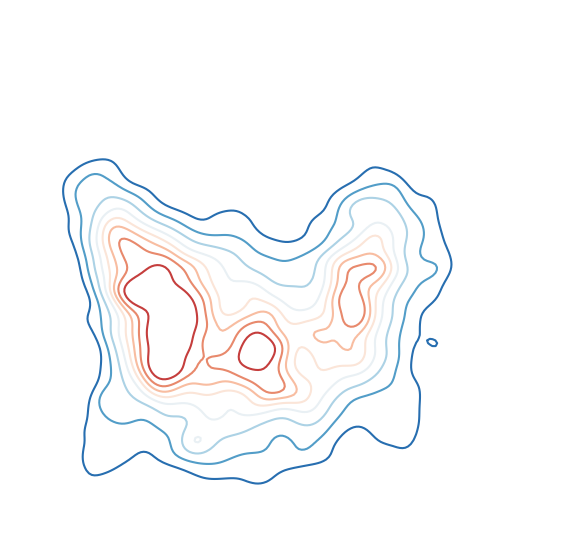

In [84]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "Pneumonia") & (event_df["IS_SILENT?"] == 0) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


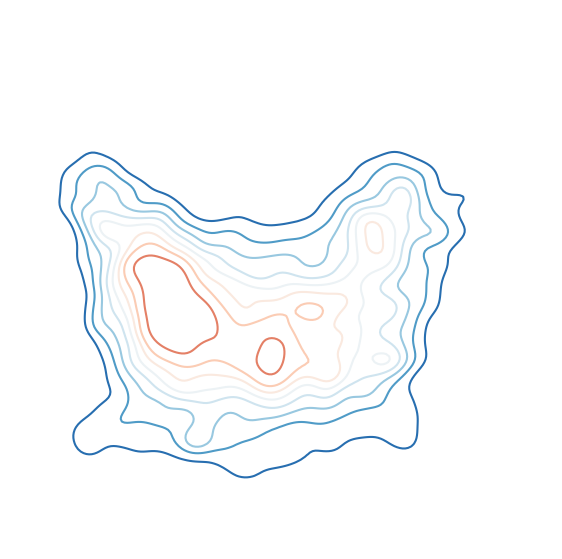

In [85]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "CHF") & (event_df["IS_SILENT?"] == 0) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


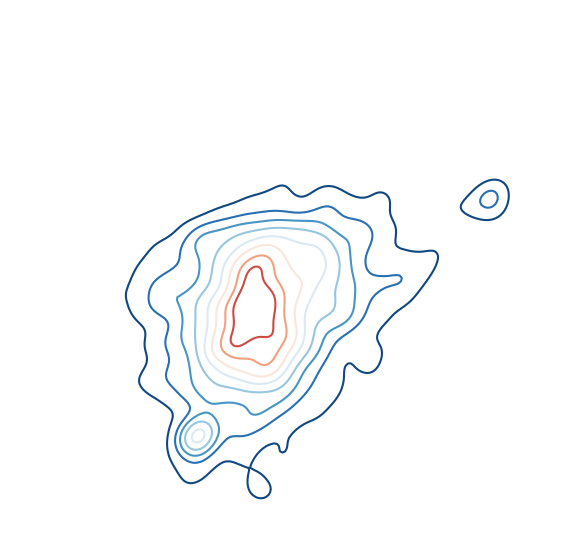

In [86]:
dataframe = event_df[ (event_df["DIAGNOSIS"] == "CHF") & (event_df["IS_SILENT?"] == 1) ]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


In [87]:
dataframe = event_df[ event_df["DIAGNOSIS"] == "CHF"]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


In [ ]:
dataframe = event_df[ event_df["DIAGNOSIS"] == "Pneumonia"]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


In [ ]:
dataframe = event_df[ event_df["DIAGNOSIS"] == "Normal"]

plt.figure(figsize=(7,7))
plt.axis('off')

hmax = sns.kdeplot(dataframe.X_ORIGINAL.values, dataframe.Y_ORIGINAL.values, cmap="RdBu_r", alpha=1)
hmax.collections[0].set_alpha(0)
plt.show()


# ANIMATION

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [ ]:
def animate(df, screen_size):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Set the axis limits based on the screen size
    ax.set_xlim((0, screen_size[0]))
    ax.set_ylim((0, screen_size[1]))
    # Initialize scatter plot with left eye positions
    scat_left = ax.scatter(df['left_eye_x'], df['left_eye_y'], color='blue')
    # Initialize scatter plot with right eye positions
    scat_right = ax.scatter(df['right_eye_x'], df['right_eye_y'], color='red')

In [ ]:
c.CACHE["OVERLAP"]

[15857729,
 15752803,
 19157903,
 17023312,
 14492434,
 19565653,
 16831446,
 13977589,
 18087960,
 11004477]

In [ ]:
patient = c.CACHE["PATIENTS"][15752803]
cxr = patient.getXray_lst()[0]
cxr.getDICOMPath()

'/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_15752803/CXR-DICOM/s51358448/cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520.dcm'

In [ ]:
eye_gaze_sheet =  "/Volumes/SD_DISK/eye_gaze.csv"
gaze_df = pd.read_csv(eye_gaze_sheet)
gaze_df.head()

,SESSION_ID,MEDIA_ID,DICOM_ID,CNT,Time (in secs),TIMETICK(f=10000000),FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,BPOGX,BPOGY,BPOGV,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,RPD,RPS,RPV,BKID,BKDUR,BKPMIN,LPMM,LPMMV,RPMM,RPMMV,SACCADE_MAG,SACCADE_DIR,VID_FRAME,X_ORIGINAL,Y_ORIGINAL
0,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,0.00000,6.962092e+11,0.26427,0.18867,0.00000,0.00000,1,0,0.52854,0.37735,1,0.38281,0.59384,17.19830,0.98505,1,0.64184,0.59797,16.76225,0.98505,1,0,0.22803,20,3.36265,1,3.44732,1,0.0,0.0,0,-2,-2
1,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,1,0.01794,6.962093e+11,0.49027,0.37940,0.00000,0.00000,1,0,0.45200,0.38146,1,0.38156,0.59378,17.47636,0.98505,1,0.64049,0.59770,17.21498,0.98505,1,0,0.00000,20,3.49799,1,3.47886,1,0.0,0.0,0,1216,1159
2,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,2,0.02826,6.962094e+11,0.47102,0.37907,0.00000,0.00000,1,0,0.45178,0.37874,1,0.38054,0.59316,16.56400,0.98505,1,0.63954,0.59721,16.91772,0.99209,1,0,0.00000,20,3.53254,1,3.63720,1,0.0,0.0,0,1105,1158
3,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,3,0.04449,6.962096e+11,0.46275,0.37678,0.00000,0.00000,1,0,0.44619,0.37220,1,0.37976,0.59301,17.02368,0.99209,1,0.63827,0.59704,17.39603,0.99912,1,0,0.00000,20,3.49934,1,3.53357,1,0.0,0.0,0,1058,1151
4,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,4,0.06177,6.962098e+11,0.46065,0.36778,0.01794,0.04382,2,1,0.45437,0.34077,1,0.37967,0.59296,16.84176,0.99912,1,0.63828,0.59696,17.44879,1.00616,1,0,0.00000,20,3.51164,1,3.50221,1,0.0,0.0,0,1046,1123


In [ ]:
from PIL import Image


img = plt.imread( cxr.getJPGPath() )

g = GazeAnalyzer( )
g.draw_raw( reading["X_ORIGINAL"].values, reading["Y_ORIGINAL"].values, imagefile = cxr.getJPGPath() )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(fig, animate, interval=20, blit=True, save_count=50)


writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)

plt.show()

<IPython.core.display.Javascript object>